# Census API
## Pulling demographic (race, income, language fluency) from the 2020 Decennial Census and American Community Survey 5-Year Estimates

In [1]:
import pygris as pg
#from pygris.data import get_census
import pandas as pd
import matplotlib.pyplot as plt
#from census import Census
import requests
import geopandas as gpd
import numpy as np

###### Get the census tracts polygon layer from the census API using the pygris module

Using the default year of 2021
Using FIPS code '42' for input 'PA'
Using FIPS code '101' for input 'Philadelphia'


<AxesSubplot: >

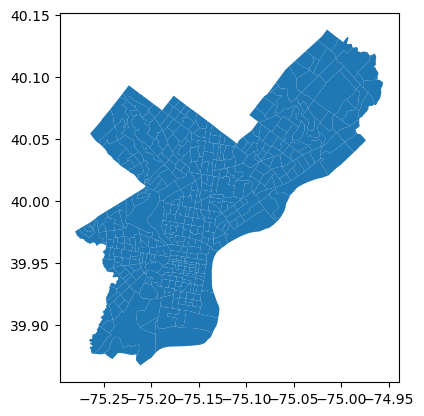

In [2]:
#get census tracts
tracts = pg.tracts("PA", "Philadelphia", cb = False, cache = True)
tracts.plot()

In [83]:
#check the tracts gdf 
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
68,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((-75.22235 39.93105, -75.22129 39.931..."
69,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,"POLYGON ((-75.20684 39.93409, -75.20655 39.934..."
70,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,"POLYGON ((-75.21243 39.92523, -75.21130 39.928..."
71,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,"POLYGON ((-75.20422 39.93285, -75.20305 39.934..."
72,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,+39.9095823,-075.1984052,"POLYGON ((-75.21612 39.90964, -75.21454 39.910..."


## Get demographic data from the census API at the tract level

### In this first pull, we pull racial data

In [4]:
#get census demographics
HOST = "https://api.census.gov/data"

year = "2020"

dataset = "dec/pl"

base_url = "/".join([HOST, year, dataset])

predicates = {}

varLst = ["NAME", "P1_001N", "P2_002N", "P2_005N", "P2_006N", "P2_008N"]

predicates["get"] = ",".join(varLst)

predicates["for"] = "tract:*"

predicates["in"] = "state: 42 & county: 101"

race = requests.get(base_url, params=predicates)

print(race.text)
    

[["NAME","P1_001N","P2_002N","P2_005N","P2_006N","P2_008N","state","county","tract"],
["Census Tract 27.01, Philadelphia County, Pennsylvania","4200","858","1861","495","796","42","101","002701"],
["Census Tract 27.02, Philadelphia County, Pennsylvania","4268","237","3497","119","211","42","101","002702"],
["Census Tract 28.01, Philadelphia County, Pennsylvania","4364","1285","1648","203","1069","42","101","002801"],
["Census Tract 28.02, Philadelphia County, Pennsylvania","5375","748","3603","69","790","42","101","002802"],
["Census Tract 29, Philadelphia County, Pennsylvania","4351","316","3487","86","259","42","101","002900"],
["Census Tract 30.01, Philadelphia County, Pennsylvania","4188","365","1381","573","1721","42","101","003001"],
["Census Tract 30.02, Philadelphia County, Pennsylvania","3529","399","1512","1153","298","42","101","003002"],
["Census Tract 31, Philadelphia County, Pennsylvania","5089","406","1693","2348","395","42","101","003100"],
["Census Tract 32, Philadelph

###### Convert the data to a dataframe
Make the data readable by changing the column names and calculate a new column to represent the population of People of Color

In [5]:
#convert to dataframe
race_df = race.json()
race_df = pd.DataFrame(race_df[1:], columns=race_df[0])
col_names_race = ["tot_pop", "hispLat_pop", "white_pop", "black_pop", "asian_pop"]
#df_r

#rename columns
for i in range(len(col_names_race)):
    race_df= race_df.rename(columns={race_df.columns[i+1]: col_names_race[i]})

#change datatype to integers
for i in race_df.columns:
    if i in col_names_race:
        race_df[i] = race_df[i].apply(lambda x: int(x))

#race_df['tot_pop'] = race_df['tot_pop'].apply(lambda x: int(x))
#race_df['white'] = race_df['white'].apply(lambda x: int(x))

#calculate new column
race_df['poc_pop'] = race_df['tot_pop'] - race_df['white_pop']

race_df

,NAME,tot_pop,hispLat_pop,white_pop,black_pop,asian_pop,state,county,tract,poc_pop
0,"Census Tract 27.01, Philadelphia County, Penns...",4200,858,1861,495,796,42,101,002701,2339
1,"Census Tract 27.02, Philadelphia County, Penns...",4268,237,3497,119,211,42,101,002702,771
2,"Census Tract 28.01, Philadelphia County, Penns...",4364,1285,1648,203,1069,42,101,002801,2716
3,"Census Tract 28.02, Philadelphia County, Penns...",5375,748,3603,69,790,42,101,002802,1772
4,"Census Tract 29, Philadelphia County, Pennsylv...",4351,316,3487,86,259,42,101,002900,864
...,...,...,...,...,...,...,...,...,...,...
403,"Census Tract 21, Philadelphia County, Pennsylv...",2462,171,1063,973,135,42,101,002100,1399
404,"Census Tract 22, Philadelphia County, Pennsylv...",2750,258,1247,939,184,42,101,002200,1503
405,"Census Tract 23, Philadelphia County, Pennsylv...",3043,385,1974,135,393,42,101,002300,1069
406,"Census Tract 24, Philadelphia County, Pennsylv...",5624,764,3361,353,908,42,101,002400,2263


### In this second pull, we pull income data

In [6]:
#get census demographics
HOST = "https://api.census.gov/data"

year = "2020"

dataset = "acs/acs5"

base_url = "/".join([HOST, year, dataset])

predicates = {}

varLst = ["NAME", "B06011_001E", "B07010_002E", "B07010_004E", "B07010_005E", "B07010_006E", "B07010_007E", "B07010_008E"]

predicates["get"] = ",".join(varLst)

predicates["for"] = "tract:*"

predicates["in"] = "state: 42 & county: 101"

income = requests.get(base_url, params=predicates)

print(income.text)
    

[["NAME","B06011_001E","B07010_002E","B07010_004E","B07010_005E","B07010_006E","B07010_007E","B07010_008E","state","county","tract"],
["Census Tract 27.01, Philadelphia County, Pennsylvania","41288","271","528","195","336","478","220","42","101","002701"],
["Census Tract 27.02, Philadelphia County, Pennsylvania","47340","281","231","250","303","402","609","42","101","002702"],
["Census Tract 28.01, Philadelphia County, Pennsylvania","29524","519","421","175","655","465","242","42","101","002801"],
["Census Tract 28.02, Philadelphia County, Pennsylvania","31703","589","749","517","522","573","504","42","101","002802"],
["Census Tract 29, Philadelphia County, Pennsylvania","48259","164","549","59","271","235","524","42","101","002900"],
["Census Tract 30.01, Philadelphia County, Pennsylvania","30094","366","670","146","525","525","469","42","101","003001"],
["Census Tract 30.02, Philadelphia County, Pennsylvania","36652","343","293","159","341","250","289","42","101","003002"],
["Census 

###### Convert the data to something easy to manipulate
Convert to a dataframe and calculate a new column to represent population whose annual income is under $50,000 by adding the categories together

In [8]:
#change col names
inc_df = income.json()
inc_df = pd.DataFrame(inc_df[1:], columns=inc_df[0])
col_names_inc = ["med_inc", "no_inc", "under_10k", "under15k", "under25k", "under35k", "under50k"]

for i in range(len(col_names_inc)):
    inc_df= inc_df.rename(columns={inc_df.columns[i+1]: col_names_inc[i]})
    
#change datatype to integers
for i in inc_df.columns:
    if i in col_names_inc:
        inc_df[i] = inc_df[i].apply(lambda x: int(x))
        
#calculate new column
inc_df['under_50k'] = inc_df['no_inc'] + inc_df['under_10k'] +inc_df['under15k'] + inc_df['under25k'] +inc_df['under35k'] +inc_df['under50k']

inc_df

,NAME,med_inc,no_inc,under_10k,under15k,under25k,under35k,under50k,state,county,tract,under_50k
0,"Census Tract 27.01, Philadelphia County, Penns...",41288,271,528,195,336,478,220,42,101,002701,2028
1,"Census Tract 27.02, Philadelphia County, Penns...",47340,281,231,250,303,402,609,42,101,002702,2076
2,"Census Tract 28.01, Philadelphia County, Penns...",29524,519,421,175,655,465,242,42,101,002801,2477
3,"Census Tract 28.02, Philadelphia County, Penns...",31703,589,749,517,522,573,504,42,101,002802,3454
4,"Census Tract 29, Philadelphia County, Pennsylv...",48259,164,549,59,271,235,524,42,101,002900,1802
...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Census Tract 9809.05, Philadelphia County, Pen...",-666666666,0,0,0,0,0,0,42,101,980905,0
404,"Census Tract 9809.06, Philadelphia County, Pen...",-666666666,0,0,0,0,0,0,42,101,980906,0
405,"Census Tract 9891, Philadelphia County, Pennsy...",11157,917,326,106,170,58,13,42,101,989100,1590
406,"Census Tract 9892, Philadelphia County, Pennsy...",-666666666,0,0,0,0,0,0,42,101,989200,0


### In this third pull, we pull English language fluency data

In [9]:
#get census demographics
HOST = "https://api.census.gov/data"

year = "2020"

dataset = "acs/acs5"

base_url = "/".join([HOST, year, dataset])

predicates = {}

varLst = ["NAME", "B06007_005E", "B06007_008E"]

predicates["get"] = ",".join(varLst)

predicates["for"] = "tract:*"

predicates["in"] = "state: 42 & county: 101"

fluency = requests.get(base_url, params=predicates)

print(fluency.text)
    

[["NAME","B06007_005E","B06007_008E","state","county","tract"],
["Census Tract 27.01, Philadelphia County, Pennsylvania","439","157","42","101","002701"],
["Census Tract 27.02, Philadelphia County, Pennsylvania","84","58","42","101","002702"],
["Census Tract 28.01, Philadelphia County, Pennsylvania","601","617","42","101","002801"],
["Census Tract 28.02, Philadelphia County, Pennsylvania","183","1088","42","101","002802"],
["Census Tract 29, Philadelphia County, Pennsylvania","108","223","42","101","002900"],
["Census Tract 30.01, Philadelphia County, Pennsylvania","0","859","42","101","003001"],
["Census Tract 30.02, Philadelphia County, Pennsylvania","3","111","42","101","003002"],
["Census Tract 31, Philadelphia County, Pennsylvania","128","35","42","101","003100"],
["Census Tract 32, Philadelphia County, Pennsylvania","34","301","42","101","003200"],
["Census Tract 33, Philadelphia County, Pennsylvania","289","224","42","101","003300"],
["Census Tract 36, Philadelphia County, Penns

###### Convert the data to something easy to manipulate
Convert to a dataframe

In [10]:
#change col names
lang_df = fluency.json()
lang_df = pd.DataFrame(lang_df[1:], columns=lang_df[0])
lang_df

col_names_lang = ["lang_sp", "lang_other"]

for i in range(len(col_names_lang)):
    lang_df= lang_df.rename(columns={lang_df.columns[i+1]: col_names_lang[i]})

#change datatype to integers
for i in lang_df.columns:
    if i in col_names_lang:
        lang_df[i] = lang_df[i].apply(lambda x: int(x))    

lang_df

,NAME,lang_sp,lang_other,state,county,tract
0,"Census Tract 27.01, Philadelphia County, Penns...",439,157,42,101,002701
1,"Census Tract 27.02, Philadelphia County, Penns...",84,58,42,101,002702
2,"Census Tract 28.01, Philadelphia County, Penns...",601,617,42,101,002801
3,"Census Tract 28.02, Philadelphia County, Penns...",183,1088,42,101,002802
4,"Census Tract 29, Philadelphia County, Pennsylv...",108,223,42,101,002900
...,...,...,...,...,...,...
403,"Census Tract 9809.05, Philadelphia County, Pen...",0,0,42,101,980905
404,"Census Tract 9809.06, Philadelphia County, Pen...",0,0,42,101,980906
405,"Census Tract 9891, Philadelphia County, Pennsy...",50,19,42,101,989100
406,"Census Tract 9892, Philadelphia County, Pennsy...",0,0,42,101,989200


### Merge census data
Merge the three separate dataframes from the census pulls, using the tract column

In [75]:
#merge DFS
#census_df = race_df.merge(inc_df, on= 'tract')
#census_df = census_df.merge(lang_df, on= 'tract')

inc_temp = inc_df[['med_inc', 'under_50k', 'tract']]

census_df = pd.merge(race_df, inc_temp, how='inner', on=['tract'])
census_df = pd.merge(census_df, lang_df, how='inner', on=['NAME','tract', 'state', 'county'])
   
#check that no rows were lost
print(len(race_df))
print(len(inc_df))
print(len(census_df))
print(len(lang_df))
census_df

408
408
408
408


,NAME,tot_pop,hispLat_pop,white_pop,black_pop,asian_pop,state,county,tract,poc_pop,med_inc,under_50k,lang_sp,lang_other
0,"Census Tract 27.01, Philadelphia County, Penns...",4200,858,1861,495,796,42,101,002701,2339,41288,2028,439,157
1,"Census Tract 27.02, Philadelphia County, Penns...",4268,237,3497,119,211,42,101,002702,771,47340,2076,84,58
2,"Census Tract 28.01, Philadelphia County, Penns...",4364,1285,1648,203,1069,42,101,002801,2716,29524,2477,601,617
3,"Census Tract 28.02, Philadelphia County, Penns...",5375,748,3603,69,790,42,101,002802,1772,31703,3454,183,1088
4,"Census Tract 29, Philadelphia County, Pennsylv...",4351,316,3487,86,259,42,101,002900,864,48259,1802,108,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Census Tract 21, Philadelphia County, Pennsylv...",2462,171,1063,973,135,42,101,002100,1399,40332,1437,25,142
404,"Census Tract 22, Philadelphia County, Pennsylv...",2750,258,1247,939,184,42,101,002200,1503,36172,1374,0,43
405,"Census Tract 23, Philadelphia County, Pennsylv...",3043,385,1974,135,393,42,101,002300,1069,34943,1603,76,536
406,"Census Tract 24, Philadelphia County, Pennsylv...",5624,764,3361,353,908,42,101,002400,2263,41800,2409,229,168


#### Normalize data by total population
Divide raw census data columns by total population and add the percentages as new columns

In [76]:
##normalize data by population

#create list of column names to normalize
col_names_race.append('poc_pop')
col_names_race.append('under_50k')
cols = [col_names_race, col_names_inc, col_names_lang]
col_names = [i for c in cols for i in c]

#divide columns by population
for col in col_names:
    if col in census_df.columns and col!= 'tot_pop' and col != 'med_inc':
        #census_df['tot_pop']= census_df['tot_pop'].apply(lambda x: int(x) for x in census_df[col])
        census_df[f'{col}_pct']= census_df[col]/census_df['tot_pop']
        
census_df

,NAME,tot_pop,hispLat_pop,white_pop,black_pop,asian_pop,state,county,tract,poc_pop,...,lang_sp,lang_other,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct
0,"Census Tract 27.01, Philadelphia County, Penns...",4200,858,1861,495,796,42,101,002701,2339,...,439,157,0.204286,0.443095,0.117857,0.189524,0.556905,0.482857,0.104524,0.037381
1,"Census Tract 27.02, Philadelphia County, Penns...",4268,237,3497,119,211,42,101,002702,771,...,84,58,0.055530,0.819353,0.027882,0.049438,0.180647,0.486410,0.019681,0.013590
2,"Census Tract 28.01, Philadelphia County, Penns...",4364,1285,1648,203,1069,42,101,002801,2716,...,601,617,0.294455,0.377635,0.046517,0.244959,0.622365,0.567599,0.137718,0.141384
3,"Census Tract 28.02, Philadelphia County, Penns...",5375,748,3603,69,790,42,101,002802,1772,...,183,1088,0.139163,0.670326,0.012837,0.146977,0.329674,0.642605,0.034047,0.202419
4,"Census Tract 29, Philadelphia County, Pennsylv...",4351,316,3487,86,259,42,101,002900,864,...,108,223,0.072627,0.801425,0.019766,0.059527,0.198575,0.414158,0.024822,0.051253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Census Tract 21, Philadelphia County, Pennsylv...",2462,171,1063,973,135,42,101,002100,1399,...,25,142,0.069456,0.431763,0.395207,0.054833,0.568237,0.583672,0.010154,0.057677
404,"Census Tract 22, Philadelphia County, Pennsylv...",2750,258,1247,939,184,42,101,002200,1503,...,0,43,0.093818,0.453455,0.341455,0.066909,0.546545,0.499636,0.000000,0.015636
405,"Census Tract 23, Philadelphia County, Pennsylv...",3043,385,1974,135,393,42,101,002300,1069,...,76,536,0.126520,0.648702,0.044364,0.129149,0.351298,0.526783,0.024975,0.176142
406,"Census Tract 24, Philadelphia County, Pennsylv...",5624,764,3361,353,908,42,101,002400,2263,...,229,168,0.135846,0.597617,0.062767,0.161451,0.402383,0.428343,0.040718,0.029872


###### Merge the census dataframe to the tracts layer as a geodataframe

In [77]:
#merge df to gdf

census_gdf = tracts.merge(census_df, left_on='TRACTCE', right_on='tract')

print(len(census_df))
print(len(census_gdf))
census_gdf.columns

census_gdf.drop('NAME_x', axis=1)
census_gdf = census_gdf.rename(columns={'NAME_y':'NAME'})

census_gdf.columns

408
408


Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'NAME', 'tot_pop', 'hispLat_pop', 'white_pop', 'black_pop',
       'asian_pop', 'state', 'county', 'tract', 'poc_pop', 'med_inc',
       'under_50k', 'lang_sp', 'lang_other', 'hispLat_pop_pct',
       'white_pop_pct', 'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct',
       'under_50k_pct', 'lang_sp_pct', 'lang_other_pct'],
      dtype='object')

In [78]:
census_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,lang_sp,lang_other,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0,0,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0
1,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0,0,0.333333,0.000000,0.500000,0.000000,1.000000,0.000000,0.0,0.0
4,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
#check data didn't get lost

print(race_df['tot_pop'].sum())
print(census_gdf['tot_pop'].sum())

print(inc_df['med_inc'].sum())
print(census_gdf['med_inc'].sum())

print(lang_df['lang_sp'].sum())
print(census_gdf['lang_sp'].sum())

1603797
1603797
-13321194886
-13321194886
66334
66334


In [82]:
#save to output folder
census_gdf.to_file("output/census_data.gpkg", driver="GPKG")

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
